In [1]:
from __future__ import unicode_literals

import sys, os
BIN = os.path.expanduser("../../../")
sys.path.append(BIN)

import numpy as np
from scipy.constants import m_p, c, e, pi
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools

from test_tools import Machine, generate_objects, BunchTracker, track, compare_traces
from test_tools import compare_projections, plot_debug_data

from PyHEADTAIL.feedback.feedback import OneboxFeedback, Kicker, PickUp
from PyHEADTAIL.feedback.processors.multiplication import ChargeWeighter
from PyHEADTAIL.feedback.processors.linear_transform import Averager
from PyHEADTAIL.feedback.processors.misc import Bypass
from PyHEADTAIL.feedback.processors.register import Register, TurnDelay, TurnFIRFilter
from PyHEADTAIL.feedback.processors.convolution import Lowpass, Gaussian, FIRFilter
from PyHEADTAIL.feedback.processors.resampling import DAC, ADC, BackToOriginalBins
from PyHEADTAIL.feedback.processors.addition import NoiseGenerator
np.random.seed(0)

PyHEADTAIL v1.13.0.17
(dirty git work tree)


--> Use the longitudinal_tracking module instead.

PyHEADTAIL_feedback v0.2




/home/lmether/Desktop/PyHEADTAIL_multibunch_merge/PyHEADTAIL_develop/PyHEADTAIL/trackers/simple_long_tracking.py:10: DeprecationWarning: 

*** DEPRECATED: "simple_long_tracking" will be replaced in a future PyHEADTAIL release!
  simple_long_tracking()


# 005 Detailed intrabunch feedback model

In this test/example, signal processors for a detailed feedback model are tested

## Basic parameters and elements for the simulations

In [2]:
n_macroparticles = 100000
n_slices = 50
n_segments = 5
n_sigma_z = 3
# n_sigma_z = 6

n_turns = 100

# Longitudinal motion of the bunch is not taken into account by default, but it can be included by uncommenting
# the line below
machine = Machine(n_segments= n_segments)
# machine = Machine(Q_s = 0.0020443)

bunch_ref, slicer_ref,trans_map, long_map = generate_objects(machine, n_macroparticles, n_slices,n_sigma_z)

*** I am rank 0 - my buckets are [0]


## Initial bunch kick
Creates an artificially (slice-by-slice) kicked bunch, which will be damped by using different feedback implementations. 

In [3]:
N_knots = 4
amplitude = 1e-3 # [m]

temp_bunch = copy.deepcopy(bunch_ref)
temp_slicer = copy.deepcopy(slicer_ref)
slice_set = temp_bunch.get_slices(temp_slicer)

slicing_length = slice_set.z_bins[-1]-slice_set.z_bins[0]
wavelength = slicing_length/((N_knots+1.)/2.)

bunch_ref.x += amplitude*np.sin(2*np.pi*(bunch_ref.z-slice_set.z_bins[0])/wavelength)
bunch_ref.y += amplitude*np.sin(2*np.pi*(bunch_ref.z-slice_set.z_bins[0])/wavelength)

## Feedback settings

In [4]:
feedback_gain = 0.1
# feedback_gain = (0.1,0.4)

# delay (a number of turns) before the pickup signal is used to the correction kick calculations.
delay = 1

# a number of values used to calculate the correct signal
n_values = 2

RMS_noise_level = 1e-6


# feedback settings
fc=1e9 # The cut off frequency of the power amplifier
ADC_f = 40e9 # multiplier of the sampling rate from the harmonic frequency
ADC_n_samples = 50
ADC_bits = 16
ADC_range = (-3e-3,3e-3)

DAC_bits = 14
DAC_range = (-3e-3,3e-3)

RMS_noise_level = 1e-6

In [5]:
# The bunch is kicked 
oscillation_wavelength = 1./2e9*c # [m]
oscillation_amplitide = 1e-3 # [m]

map_min = (bunch_ref.z > -80)
map_max = (bunch_ref.z < -40)
map_total = map_min*map_max

# bunch_ref.x[map_total] = bunch_ref.x[map_total]+1e-3
# bunch_ref.y[map_total] = bunch_ref.y[map_total]+1e-3

bunch_ref.x += oscillation_amplitide*np.sin(2*np.pi*bunch_ref.z/oscillation_wavelength)
bunch_ref.y += oscillation_amplitide*np.sin(2*np.pi*bunch_ref.z/oscillation_wavelength)
    
bunch_init = copy.deepcopy(bunch_ref)
tracker_ref = BunchTracker(bunch_init)
maps_ref = [i for i in trans_map]
# + [long_map]
track(n_turns, bunch_init,maps_ref,tracker_ref)

## Reference data
Tracks a bunch by using a charge weighted ideal slice-by-slice feedback system presented in the previous test. This data are used as a reference data for the feedback model including multiple pickups and kickers. The data are used as a reference data for the detailed intra bunch feedback model.

In [6]:
bunch_ref_data = copy.deepcopy(bunch_ref)
tracker_ref_data = BunchTracker(bunch_ref_data)
slicer_ref_data = copy.deepcopy(slicer_ref)

processors_bunch_x = [
    ChargeWeighter()
]
processors_bunch_y = [
    ChargeWeighter()
]

feedback_map = OneboxFeedback(feedback_gain,slicer_ref_data,processors_bunch_x,processors_bunch_y)
one_turn_map = [i for i in trans_map] + [feedback_map] + [long_map]

track(n_turns, bunch_ref_data ,one_turn_map,tracker_ref_data)

## Detailed feedback model
Signal processors required for a detailed model of the transverse feedback system are tested here. Note that the tested system does not describe accurately any existing system, and the details of the models might affect significantly to the simulation results.

### FIR filter coefficients for the bandwidth phase correction
The bandwidth of this model is limited by using a 1st order lowpass filter, which has non-linear phase response. The phase of the filter is linearized by using a FIR filter. The filter coefficients are from Ref.  https://accelconf.web.cern.ch/accelconf/e08/papers/thpc122.pdf . Note that this is a test example and the coefficients are designed to the intrabunch feedback nor tuned to work perfectly with this model.

In [7]:
# Coefficients from 
FIR_filter = [0.0096,  0.0192,  0.0481,  0.0673,  0.0769,  0.1154,
                0.1442,  0.1442,  0.2115,  0.2403,  0.2596,  0.3077,
                0.3558,  0.3846,  0.4519,  0.5192,  0.6346,  0.75,
                0.9519,  1.2019,  1.6346,  2.6346,  7.0192, -5.1923,
                -1.4135, -0.6827, -0.3942, -0.2308, -0.1442, -0.096,
                -0.0192, -0.0096]
FIR_filter = np.array(FIR_filter)
FIR_filter = FIR_filter/sum(FIR_filter)

### Turn-by-turn FIR filter for the betatron phase correction
The betatron phase correction is implemented manually by using a turn-by-turn FIR filter. Coefficients are from Ref. http://accelconf.web.cern.ch/AccelConf/IPAC2011/papers/mopo013.pdf, but they are not optimized to this model.

In [8]:
# the total (group) delay to the middle coefficient is four turns, i.e.
phase_shift_x = -4. * machine.Q_x * 2.* pi
turn_FIR_filter_x = [-2. * np.sin(phase_shift_x)/(pi * 3.),
                   0,
                   -2. * np.sin(phase_shift_x)/(pi * 1.),
                   np.cos(phase_shift_x),
                   2. * np.sin(phase_shift_x)/(pi * 1.),
                   0,
                   2. * np.sin(phase_shift_x)/(pi * 3.)
                   ]

phase_shift_y = -4. * machine.Q_y * 2.* pi
turn_FIR_filter_y = [-2. * np.sin(phase_shift_y)/(pi * 3.),
                   0,
                   -2. * np.sin(phase_shift_y)/(pi * 1.),
                   np.cos(phase_shift_y),
                   2. * np.sin(phase_shift_y)/(pi * 1.),
                   0,
                   2. * np.sin(phase_shift_y)/(pi * 3.)
                   ]


### The model
This model includes elements for digital signal processing (ADC, FIR filters and DAC) and power amplifier/kicker bandwidth limitation. A model for pickup could be built, but in this test a charge weighted signal (𝛥-signal) is used (read more about this choice from the previous test).

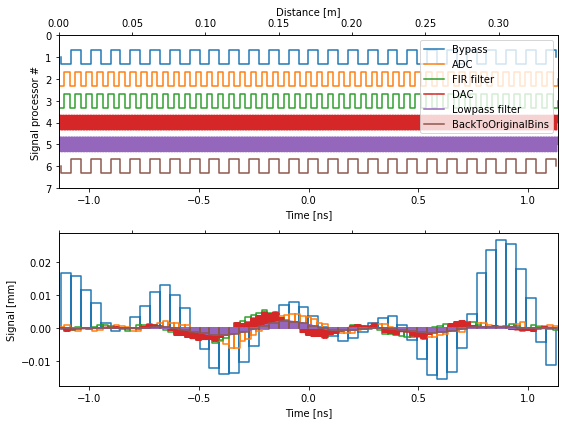

(<Figure size 576x432 with 4 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcdfbc55f10>)

In [9]:
bunch_detailed = copy.deepcopy(bunch_ref)
tracker_detailed = BunchTracker(bunch_detailed)
slicer_detailed = copy.deepcopy(slicer_ref)

processors_detailed_x = [
        Bypass(debug=True),
        ChargeWeighter(debug=False),
        NoiseGenerator(RMS_noise_level, debug=False),
        ADC(ADC_f, ADC_bits, ADC_range, n_samples=None, debug=True),
        FIRFilter(FIR_filter, zero_tap = 23, debug=True),
        TurnFIRFilter(turn_FIR_filter_x, machine.Q_x, delay = 1, debug=False),
        DAC(ADC_bits, ADC_range, debug=True),
        Lowpass(fc, f_cutoff_2nd=4*fc, debug=True),
        BackToOriginalBins(debug=True),
]

processors_detailed_y = [
        Bypass(debug=True),
        ChargeWeighter(debug=True),
        NoiseGenerator(RMS_noise_level, debug=True),
        ADC(ADC_f, ADC_bits, ADC_range, n_samples=ADC_n_samples, debug=True),
        FIRFilter(FIR_filter, zero_tap = 23, debug=True),
        TurnFIRFilter(turn_FIR_filter_y, machine.Q_y, delay = 1, debug=True),
        DAC(ADC_bits, ADC_range, debug=True),
        Lowpass(fc, f_cutoff_2nd=4*fc, debug=True),
        BackToOriginalBins(debug=True),
]


feedback_map = OneboxFeedback(feedback_gain,slicer_detailed,
                              processors_detailed_x,processors_detailed_y)
one_turn_map = [feedback_map] + [i for i in trans_map] # + [long_map]

track(n_turns, bunch_detailed, one_turn_map, tracker_detailed)
plot_debug_data(processors_detailed_x, source = 'output')

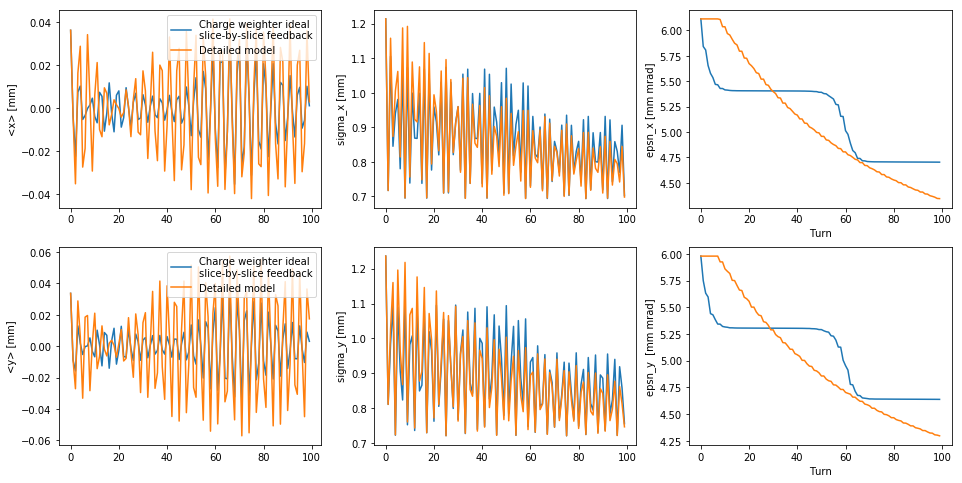

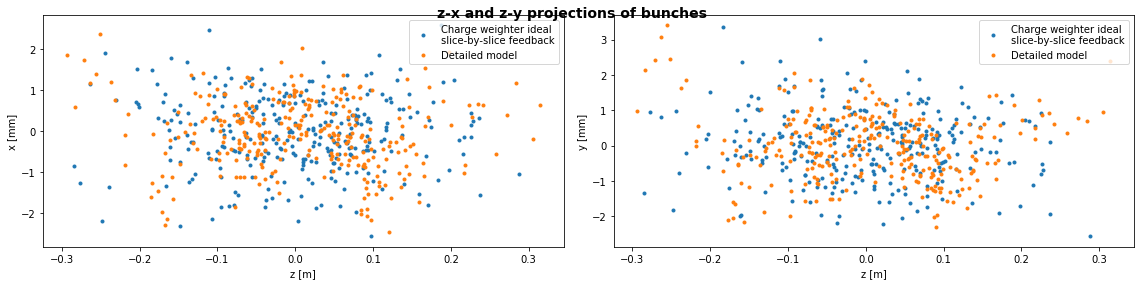

In [10]:
# In here, the traces and the projections from different implementations of the feedback system are compared.
# Note: the properties are calculated over all particles in all bunches
# Note: the scale in the emittance figures

compare_traces([tracker_ref_data,tracker_detailed],
               ['Charge weighter ideal\nslice-by-slice feedback', 'Detailed model'])
compare_projections([ bunch_ref_data,  bunch_detailed], 
                    ['Charge weighter ideal\nslice-by-slice feedback', 'Detailed model'])

# compare_traces([tracker_OneBox_bunch,tracker_register_example],
#                ['Ideal', 'Delayed', 'Separated'])
# compare_projections([ bunch_OneBox_bunch,  bunch_register_example], 
#                     ['Ideal', 'Delayed', 'Separated'])

Jani Komppula, CERN, 2017